Tutorial 5 shows how to use random search to find the optimal configuration of hyperparameters and layer choices for the Bert model.

Now, explore using the GridSampler and TPESampler in Optuna.

Plot a figure that has the number of trials on the x axis, and the maximum achieved accuracy up to that point on the y axis. Plot one curve for each sampler to compare their performance.

In Tutorial 5, NAS is used to find an optimal configuration of hyperparameters, then we use the CompressionPipeline in Mase to quantize and prune the model after search is finished. However, the final compressed model may not be optimal, since different model architectures may have different sensitivities to quantization and pruning. Ideally, we want to run a compression-aware search flow, where the quantization and pruning is considered in each trial.

In the objective function, after the model is constructed and trained for some iterations, call the CompressionPipeline to quantize and prune the model, then continue training for a few more epochs. Use the sampler that yielded the best results in Task 1 to run the compression-aware search. The objective function should return the final accuracy of the model after compression. Consider also the case where final training is performed after quantization/pruning.

Plot a new figure that has the number of trials on the x axis, and the maximum achieved accuracy up to that point on the y axis. There should be three curves: 1. the best performance from Task 1 (without compression), compression-aware search without post-compression training, and compression-aware search with post-compression training.

## sampler 第二题是不对的


## 第一题也可能不对

In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)


import torch.nn as nn
from chop.nn.modules import Identity

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr


def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        # print(param,'idx', chosen_idx)
        setattr(config, param, search_space[param][chosen_idx])
        # setattr(config, param, chosen_idx)

    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )
            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model

from chop.tools import get_trainer


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    # Set the model as an attribute so we can fetch it later
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [30]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = TPESampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=10,
    timeout=60 * 60 * 24,
)

from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

with open(f"{Path.home()}/tutorial_5_best_model_TPESampler.pkl", "wb") as f:
    dill.dump(model, f)

    

[I 2025-01-30 12:10:23,160] A new study created in memory with name: bert-tiny-nas-study


Trial 0 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


[W 2025-01-30 12:10:25,677] Trial 0 failed with parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 256, 'intermediate_size': 768} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_791/779819256.py", line 60, in objective
    trainer.train()
  File "/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/transformers/trainer.py", line 2171, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/transformers/trainer.py", line 2597, in _inner_training_loop
    self.control = self.callback_handler.on_step_end(args, self.state, self.control)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srcPkgs/miniconda

KeyboardInterrupt: 

In [37]:
task1_accuracies_TPESampler = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]

In [38]:
task1_accuracies_TPESampler

[0.83984,
 0.84352,
 0.85224,
 0.85224,
 0.85224,
 0.85224,
 0.85224,
 0.85224,
 0.86704,
 0.86704]

[Gridsearch](https://blog.csdn.net/qq_42147816/article/details/129335251)

In [32]:
import random
search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [0, 1],  
}

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_categorical(param, search_space[param])
        setattr(config, param, chosen_idx)

    trial_model = AutoModelForSequenceClassification.from_config(config)
    linear_layer_mapping = {0: nn.Linear, 1: Identity}
    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                "linear_layer_choices",
                search_space["linear_layer_choices"],
            )
            new_layer_cls=linear_layer_mapping[new_layer_cls]
            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model

from optuna.samplers import GridSampler, RandomSampler, TPESampler
sampler = GridSampler(search_space)

sampler = GridSampler(search_space)
for i, combination in enumerate(sampler._all_grids):
    print(f"Combination {i}: {combination}")

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=10,
    timeout=60 * 60 * 24,
)


[I 2025-01-30 12:31:18,028] A new study created in memory with name: bert-tiny-nas-study


Combination 0: (384, 768, 1, 2, 2)
Combination 1: (384, 512, 0, 2, 2)
Combination 2: (128, 512, 0, 4, 2)
Combination 3: (192, 1024, 0, 2, 4)
Combination 4: (128, 512, 0, 8, 8)
Combination 5: (512, 1024, 0, 2, 8)
Combination 6: (192, 768, 1, 16, 8)
Combination 7: (128, 512, 1, 4, 2)
Combination 8: (512, 768, 0, 16, 4)
Combination 9: (384, 1024, 0, 8, 2)
Combination 10: (512, 768, 1, 8, 4)
Combination 11: (128, 1024, 0, 2, 2)
Combination 12: (512, 512, 1, 2, 4)
Combination 13: (512, 512, 1, 8, 4)
Combination 14: (384, 1024, 1, 4, 8)
Combination 15: (512, 768, 1, 4, 4)
Combination 16: (256, 768, 1, 16, 8)
Combination 17: (384, 1536, 0, 8, 2)
Combination 18: (256, 1024, 0, 8, 8)
Combination 19: (128, 2048, 0, 4, 2)
Combination 20: (256, 2048, 0, 4, 2)
Combination 21: (256, 768, 0, 16, 8)
Combination 22: (256, 2048, 1, 4, 4)
Combination 23: (512, 1536, 0, 2, 8)
Combination 24: (256, 768, 1, 2, 2)
Combination 25: (192, 1024, 1, 8, 8)
Combination 26: (384, 1024, 0, 16, 4)
Combination 27: (128

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.699000
1000,0.670000
1500,0.552900
2000,0.480400
2500,0.447800
3000,0.446600


[I 2025-01-30 12:33:20,326] Trial 0 finished with value: 0.82236 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 768, 'linear_layer_choices': 1}. Best is trial 0 with value: 0.82236.


Trial 1 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656500
1000,0.498000
1500,0.419900
2000,0.365000
2500,0.326100
3000,0.343000


[I 2025-01-30 12:35:41,936] Trial 1 finished with value: 0.86468 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 384, 'intermediate_size': 512, 'linear_layer_choices': 0}. Best is trial 1 with value: 0.86468.


Trial 2 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693400
1000,0.622300
1500,0.477600
2000,0.408400
2500,0.375400
3000,0.376900


[I 2025-01-30 12:37:29,841] Trial 2 finished with value: 0.84284 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_choices': 0}. Best is trial 1 with value: 0.86468.


Trial 3 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694600
1000,0.562500
1500,0.441300
2000,0.382500
2500,0.338000
3000,0.364400


[I 2025-01-30 12:39:21,997] Trial 3 finished with value: 0.85696 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 1024, 'linear_layer_choices': 0}. Best is trial 1 with value: 0.86468.


Trial 4 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693400
1000,0.622300
1500,0.477600
2000,0.408400
2500,0.375400
3000,0.376900


[I 2025-01-30 12:41:00,350] Trial 4 finished with value: 0.84284 and parameters: {'num_layers': 8, 'num_heads': 8, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_choices': 0}. Best is trial 1 with value: 0.86468.


Trial 5 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.650700
1000,0.498500
1500,0.396600
2000,0.351500
2500,0.332700
3000,0.349300


[I 2025-01-30 12:44:08,727] Trial 5 finished with value: 0.86588 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 512, 'intermediate_size': 1024, 'linear_layer_choices': 0}. Best is trial 5 with value: 0.86588.


Trial 6 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692500
1000,0.632900
1500,0.522600
2000,0.467300
2500,0.446600
3000,0.438300


[I 2025-01-30 12:45:51,210] Trial 6 finished with value: 0.81552 and parameters: {'num_layers': 8, 'num_heads': 16, 'hidden_size': 192, 'intermediate_size': 768, 'linear_layer_choices': 1}. Best is trial 5 with value: 0.86588.


Trial 7 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692900
1000,0.677300
1500,0.594500
2000,0.498500
2500,0.458200
3000,0.453300


[I 2025-01-30 12:47:27,207] Trial 7 finished with value: 0.81208 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 128, 'intermediate_size': 512, 'linear_layer_choices': 1}. Best is trial 5 with value: 0.86588.


Trial 8 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.644100
1000,0.469300
1500,0.385400
2000,0.350200
2500,0.325300
3000,0.347200


[I 2025-01-30 12:50:32,944] Trial 8 finished with value: 0.8654 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 768, 'linear_layer_choices': 0}. Best is trial 5 with value: 0.86588.


Trial 9 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.655000
1000,0.472800
1500,0.414200
2000,0.356000
2500,0.327200
3000,0.335900


[I 2025-01-30 12:53:22,707] Trial 9 finished with value: 0.86684 and parameters: {'num_layers': 2, 'num_heads': 8, 'hidden_size': 384, 'intermediate_size': 1024, 'linear_layer_choices': 0}. Best is trial 9 with value: 0.86684.


In [33]:
task1_accuracies_GridSampler = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]

In [34]:
task1_accuracies_GridSampler

[0.82236,
 0.86468,
 0.86468,
 0.86468,
 0.86468,
 0.86588,
 0.86588,
 0.86588,
 0.86588,
 0.86684]

In [4]:
task1_accuracies_GridSampler_pre

[0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86748,
 0.86748,
 0.86748]

In [17]:
import optuna
from optuna.samplers import GridSampler
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
from chop.tools import get_trainer
import torch.nn as nn
from chop.nn.modules import Identity
from pathlib import Path
import dill

# 定义搜索空间
search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": ["Linear", "Identity"],  # 名称应与 trial.params 中的键一致
}


# 构建模型函数
def construct_model(trial):
    config = AutoConfig.from_pretrained("prajjwal1/bert-tiny")

    for param in ["num_layers", "num_heads", "hidden_size", "intermediate_size"]:
        if param not in trial.params:
            raise KeyError(f"Parameter '{param}' is missing in trial.params")
        value = trial.params[param]
        setattr(config, param, value)

    trial_model = AutoModelForSequenceClassification.from_config(config)

    linear_layer_mapping = {"Linear": nn.Linear, "Identity": Identity}
    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            param_name = f"{name}_type"
            if param_name not in trial.params:
                raise KeyError(f"Parameter '{param_name}' is missing in trial.params")
            new_layer_type = trial.params[param_name]
            new_layer_cls = linear_layer_mapping[new_layer_type]
            if new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)

    return trial_model

# 目标函数
def objective(trial):
    print(f"Trial {trial.number} parameters: {trial.params}")

    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

# 获取数据集和分词器
from chop.tools import get_tokenized_dataset

dataset_name = "imdb"
tokenizer_checkpoint = "bert-base-uncased"
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# 初始化 GridSampler
sampler = GridSampler(search_space)

# 检查采样参数
for i, combination in enumerate(sampler._all_grids):
    print(f"Combination {i}: {combination}")

# 创建 Study
study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

# 启动优化
study.optimize(objective, timeout=60 * 60 * 24)

# 保存最佳模型
best_model = study.best_trial.user_attrs["model"].cpu()

model_path = f"{Path.home()}/tutorial_5_best_model.pkl"
with open(model_path, "wb") as f:
    dill.dump(best_model, f)

print(f"Best Trial Params: {study.best_trial.params}")
print(f"Best Trial Accuracy: {study.best_trial.value}")
print(f"Best model saved to {model_path}")


INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
[I 2025-01-30 11:47:41,829] A new study created in memory with name: bert-tiny-nas-study
[W 2025-01-30 11:47:41,928] Trial 0 failed with parameters: {} because of the following error: KeyError("Parameter 'num_layers' is missing in trial.params").
Traceback (most recent call last):
  File "/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_791/1108791313.py", line 51, in objective
    model = construct_model(trial)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_791/1108791313.py", line 27, in construct_model
    raise KeyError(f"Parameter '{param}' is missing in trial.params")
KeyError: "Parameter 'num_layers' is missing in trial.params"
[W 2025-01-30 11:47:41,929] Trial 0 failed with value None.


Combination 0: (128, 768, 'Linear', 8, 2)
Combination 1: (192, 768, 'Linear', 4, 2)
Combination 2: (256, 768, 'Linear', 16, 8)
Combination 3: (512, 512, 'Identity', 16, 8)
Combination 4: (256, 1024, 'Linear', 8, 2)
Combination 5: (512, 2048, 'Linear', 16, 4)
Combination 6: (384, 512, 'Linear', 4, 4)
Combination 7: (384, 2048, 'Identity', 2, 2)
Combination 8: (512, 1024, 'Identity', 2, 4)
Combination 9: (384, 768, 'Identity', 4, 8)
Combination 10: (192, 2048, 'Identity', 8, 2)
Combination 11: (128, 768, 'Identity', 4, 8)
Combination 12: (192, 1536, 'Identity', 4, 8)
Combination 13: (256, 768, 'Linear', 4, 2)
Combination 14: (256, 512, 'Identity', 4, 2)
Combination 15: (512, 768, 'Linear', 2, 4)
Combination 16: (256, 1024, 'Identity', 8, 2)
Combination 17: (384, 2048, 'Linear', 4, 8)
Combination 18: (384, 1536, 'Linear', 4, 2)
Combination 19: (192, 1024, 'Linear', 4, 4)
Combination 20: (384, 768, 'Identity', 4, 4)
Combination 21: (384, 512, 'Identity', 8, 4)
Combination 22: (256, 1024, '

KeyError: "Parameter 'num_layers' is missing in trial.params"

In [ ]:
task1_accuracies_GridSampler = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]

In [20]:
for t in study.trials:
    print(f"Trial {t.number}:")
    print(f"  Params: {t.params}")
    print(f"  Accuracy: {t.value}")
    # print(f"  User Attributes: {t.user_attrs}")
    # print()

Trial 0:
  Params: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 2, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}
  Accuracy: 0.8594
  User Attributes: {'model': BertForSequenceClassification(
  (bert): BertMo

## Deploying the Optimized Model with CompressionPipeline


In [18]:
from chop.pipelines import CompressionPipeline
from chop import MaseGraph

mg = MaseGraph(model)
pipe = CompressionPipeline()

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = pipe(
    mg,
    pass_args={
        "quantize_transform_pass": quantization_config,
        "prune_transform_pass": pruning_config,
    },
)

/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads alwa

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.0194,  0.1843, -0.0334,  ..., -0.4037, -0.2655,  0.2391],
         [ 0.1121,  0.2651, -0.2144,  ..., -0.6956, -0.3653,  0.4728],
         [-0.1428,  0.3953,  0.1687,  ..., -0.0550, -0.5371,  0.1282],
         ...,
         [-0.0504,  0.1574,  0.2823,

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


In [19]:
mg.export(f"{Path.home()}/tutorial_5_nas_compressed")

INFO     Exporting MaseGraph to /root/tutorial_5_nas_compressed.pt, /root/tutorial_5_nas_compressed.mz
INFO     Exporting GraphModule to /root/tutorial_5_nas_compressed.pt


RuntimeError: Serialization of parametrized modules is only supported through state_dict(). See:
https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training

In [ ]:
# 保存 Task 1 的结果
task1_accuracies = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]


In [25]:
import torch
import optuna
from optuna.samplers import TPESampler
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')


def objective(trial, post_compression_training):
    print(f"Trial {trial.number} parameters: {trial.params}")
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    
    mg = MaseGraph(
        model.cpu(),
        hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
        ],
    )
    pipe = CompressionPipeline()

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }

    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0, 
    )
    eval_results = trainer.evaluate()

    if post_compression_training:
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1, 
        )
        trainer.train()
        eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

def objective_no_train(trial):
    return objective(trial, post_compression_training=False)

def objective_with_train(trial):
    return objective(trial, post_compression_training=True)

sampler = TPESampler()

# 压缩后无训练
study_no_train = optuna.create_study(
    direction="maximize",
    study_name='lab2-2',
    sampler=sampler,
)
study_no_train.optimize(
    objective_no_train, 
    n_trials=10, 
    timeout=60*60*24
)

task2_no_train_accuracies = [
    max([t.value for t in study_no_train.trials[:i+1]]) for i in range(len(study_no_train.trials))
]

# 压缩后有训练
study_with_train = optuna.create_study(
    direction="maximize",
    study_name='lab2-3',
    sampler=sampler,
)
study_with_train.optimize(
    objective_with_train, 
    n_trials=10, 
    timeout=60*60*24
)

task2_with_train_accuracies = [
    max([t.value for t in study_with_train.trials[:i+1]]) for i in range(len(study_with_train.trials))
]


[I 2025-01-26 00:24:37,774] A new study created in memory with name: lab2-2
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Trial 0 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.692600
1000,0.521100
1500,0.410100
2000,0.388500
2500,0.339200
3000,0.359900


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.1767,  0.0040,  0.5388,  ...,  0.4770,  0.2094, -0.0327],
         [ 0.4176, -0.0068, -0.3657,  ...,  0.5857,  0.0066, -0.5130],
         [ 0.1865, -0.2770,  0.0084,  ..., -0.0510,  0.1975, -0.1196],
         ...,
         [ 0.0799,  0.0627, -0.3469,  ...,  0.6806,  0.1839, -0.8873],
         [ 0.0835, -0.2969, -0.0076,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:27:37,306] Trial 0 finished with value: 0.75448 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with value

Trial 1 parameters: {}


Step,Training Loss
500,0.693200
1000,0.542300
1500,0.430000
2000,0.393000
2500,0.338000
3000,0.365000


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.7053, -0.1690,  0.3168,  ..., -0.3110,  0.2122,  0.1701],
         [ 0.3243, -0.0044, -1.0689,  ..., -0.3445, -0.0065,  0.6010],
         [ 0.4483, -0.3603,  0.1586,  ..., -0.3948, -0.7535,  0.5749],
         ...,
         [ 0.1343, -0.1577,  0.1570,  ...,  0.0571, -0.0267, -0.1746],
         [-0.2388,  0.0270,  0.3401,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:30:00,322] Trial 1 finished with value: 0.58756 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 2, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with value: 0

Trial 2 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.693300
1000,0.614500
1500,0.439500
2000,0.416100
2500,0.377800
3000,0.392100


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_de

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-5.0475e-02,  3.1415e-01, -2.8741e-01,  ...,  5.4448e-01,
           1.5683e-01,  5.7752e-01],
         [-9.6667e-02, -4.5106e-01, -1.1214e-01,  ..., -4.8727e-02,
           2.5575e-01,  3.3525e-01],
         [ 2.4064e-01, -9.9646e-02, -3.5975e-02,  ...,  2.2691e-01,
           8.6860e-03,  4.0626e-01],
         ...,
         [ 3.9

[I 2025-01-26 00:32:05,374] Trial 2 finished with value: 0.77064 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value: 0.77

Trial 3 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.680800
1000,0.506800
1500,0.428300
2000,0.382400
2500,0.335700
3000,0.335900


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-0.5168, -0.1287,  0.0269,  ..., -0.0352,  0.3873,  0.5293],
         [-0.6322,  0.3570,  0.2943,  ..., -0.4050,  0.1243,  0.1088],
         [ 0.7515, -0.0127,  0.6391,  ..., -1.0627,  0.0846, -0.1181],
         ...,
         [ 0.4235, -0.0062,  0.6859,  ..., -0.0559,  0.9448,  0.0580],
         [-0.1083, -0.3325,  0.5507,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:36:35,626] Trial 3 finished with value: 0.69672 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 4, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value: 0

Trial 4 parameters: {}


Step,Training Loss
500,0.693500
1000,0.560300
1500,0.437800
2000,0.401500
2500,0.357600
3000,0.369800


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_outpu

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-2.8184,  2.0182,  0.5308,  ..., -0.1977, -0.0607,  0.3913],
         [-0.0000,  0.9993, -1.2789,  ..., -0.7567,  0.2222, -0.2667],
         [-0.2112,  1.1775, -1.4864,  ..., -0.7598,  0.4749,  1.4346],
         ...,
         [-1.2333,  0.2878, -0.6698,  ..., -0.0000,  2.5164,  0.4047],
         [-3.1001,  0.3910, -0.4430,  ...,  0

[I 2025-01-26 00:38:42,760] Trial 4 finished with value: 0.73164 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 2 with value: 0.77

Trial 5 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.692900
1000,0.514300
1500,0.410900
2000,0.378200
2500,0.340100
3000,0.350900


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-0.4917,  0.2283, -0.0100,  ..., -0.2284,  0.2703,  0.3542],
         [-0.7141, -0.5101, -0.3824,  ...,  0.0640, -0.1213,  0.3178],
         [-0.9340,  0.2670, -0.4796,  ..., -0.2164, -0.0171,  0.2057],
         ...,
         [ 0.1209,  0.0238, -0.0665,  ...,  0.4190, -0.7461,  0.3170],
         [-0.5392,  0.1921, -0.1743,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:41:11,774] Trial 5 finished with value: 0.60456 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 2, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 2 with

Trial 6 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.692800
1000,0.555300
1500,0.458000
2000,0.419600
2500,0.369500
3000,0.390800


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-0.4550,  1.4766, -0.0337,  ..., -1.2193,  0.0217,  0.5129],
         [ 2.0991, -0.5744, -1.5112,  ..., -0.4918,  0.3367,  0.1739],
         [ 0.2809, -0.8533, -0.6081,  ..., -0.6424,  0.1085,  1.3411],
         ...,
         [ 1.8539, -0.3034,  1.1634,  ...,  0.0000, -1.8933,  0.0000],
         [ 0.0000,  0.0000, -1.5414,  ..., -1

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:43:35,846] Trial 6 finished with value: 0.82256 and parameters: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 6 with va

Trial 7 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.677900
1000,0.497100
1500,0.409300
2000,0.378500
2500,0.335500
3000,0.352200


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.9988, -1.9561, -0.2002,  ...,  0.1767,  0.0047,  0.8356],
         [ 0.9527, -1.2374, -2.1681,  ...,  0.7427,  0.7189,  1.7942],
         [ 0.6018, -0.5854, -1.6172,  ...,  1.9213,  0.1756,  0.4724],
         ...,
         [ 0.2238, -1.1229, -1.9580,  ...,  0.0000,  0.0402, -0.0000],
         [ 0.0000, -0.0000,  0.4319,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:47:00,982] Trial 7 finished with value: 0.82156 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 3, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 6 with va

Trial 8 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.660500
1000,0.502100
1500,0.430600
2000,0.380100
2500,0.328400
3000,0.345000


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.5817,  0.4826,  0.3873,  ..., -0.5440, -0.4352, -0.3649],
         [-0.1125, -0.0343,  0.1247,  ...,  0.2993, -0.4498,  0.0488],
         [ 0.1462, -0.6107,  0.7218,  ..., -0.8181,  0.7258, -0.1035],
         ...,
         [ 1.0979,  0.4236,  1.2508,  ..., -0.2212, -0.6522, -0.3054],
         [ 0.6811, -0.1231,  0.9033,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:51:00,780] Trial 8 finished with value: 0.83404 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 4, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 8 with value: 0.83404

Trial 9 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.695200
1000,0.552800
1500,0.465500
2000,0.419400
2500,0.355900
3000,0.370700


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.5196, -1.2372,  1.1381,  ...,  1.3813,  0.2277, -1.3331],
         [-0.0000, -0.6022, -0.1848,  ...,  0.0000,  0.5814,  0.0000],
         [-1.2329, -0.9070, -1.4272,  ...,  0.4060,  1.4416,  2.0073],
         ...,
         [ 0.1305, -1.9856, -0.5185,  ...,  3.2975, -0.9629,  0.4293],
         [-1.0323, -0.0000,  0.2267,  ...,  1

INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


[I 2025-01-26 00:53:41,876] Trial 9 finished with value: 0.56744 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 2, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 8 w

Trial 0 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.687600
1000,0.482800
1500,0.382300
2000,0.361900
2500,0.315900
3000,0.344500


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.3880,  0.5982,  0.1448,  ...,  0.4106,  0.3948,  0.0741],
         [-0.0105,  0.0593,  0.0150,  ...,  0.0629,  0.1203,  0.0563],
         [ 0.4146,  0.5211,  0.2774,  ..., -0.6333,  0.4491, -0.7251],
         ...,
         [ 0.0911,  0.0781,  0.7655,  ...,  0.2534,  0.3842, -0.1089],
         [ 0.0346, -0.0054,  0.3848,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


Step,Training Loss
500,0.309800
1000,0.231300
1500,0.248900
2000,0.264100
2500,0.258200
3000,0.292900


[I 2025-01-26 01:02:04,224] Trial 0 finished with value: 0.86188 and parameters: {'num_layers': 2, 'num_heads': 3, 'hidden_size': 3, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 0 with value: 0.86188

Trial 1 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.695600
1000,0.567400
1500,0.466600
2000,0.423500
2500,0.356300
3000,0.376000


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 1.9796, -1.3186,  0.1407,  ...,  0.6902,  0.4310,  0.6408],
         [ 0.0000, -0.4863,  0.8809,  ..., -0.0000,  0.3680,  0.0000],
         [ 3.7023, -1.6818, -0.6288,  ...,  0.4458, -0.7131,  1.1181],
         ...,
         [ 2.5194, -1.4253,  1.3280,  ...,  1.3220,  0.7524,  1.5101],
         [ 1.5392, -0.0000,  0.8132,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Step,Training Loss
500,0.379900
1000,0.297300
1500,0.285100
2000,0.284100
2500,0.275300
3000,0.317800


[I 2025-01-26 01:08:11,262] Trial 1 finished with value: 0.87152 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 2, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with

Trial 2 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.681200
1000,0.493500
1500,0.390500
2000,0.361600
2500,0.315900
3000,0.336500


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.7779, -1.9307,  0.7602,  ..., -0.0000,  0.5287,  0.0000],
         [ 0.2892,  0.6976,  0.6303,  ...,  0.0000,  1.0196,  0.0380],
         [ 0.3520, -0.8003,  0.6819,  ...,  0.0000, -0.7941, -0.3770],
         ...,
         [-0.4078, -0.7246,  0.1045,  ..., -1.0863,  0.8832,  0.4677],
         [-0.0000, -0.1903,  0.8932,  ...,  1

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Step,Training Loss
500,0.307200
1000,0.230900
1500,0.238000
2000,0.258900
2500,0.247800
3000,0.290900


[I 2025-01-26 01:16:09,764] Trial 2 finished with value: 0.86212 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 4, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with value: 0

Trial 3 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.694900
1000,0.660700
1500,0.525700
2000,0.481700
2500,0.433400
3000,0.443600


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-0.0994,  0.3909,  1.4734,  ...,  0.1043, -0.8707, -1.0035],
         [ 0.0000, -0.9270,  0.6704,  ...,  0.7849, -0.6422, -0.9018],
         [ 0.9422, -0.1871,  0.4529,  ...,  0.6691, -1.4526,  1.3091],
         ...,
         [ 0.0552,  0.2968, -0.1663,  ...,  0.0000, -1.8227,  0.7854],
         [-0.4227,  0.0349, -0.5598,  ..., -0

Step,Training Loss
500,0.438500
1000,0.343000
1500,0.348000
2000,0.352500
2500,0.336900
3000,0.370900


[I 2025-01-26 01:20:19,727] Trial 3 finished with value: 0.86372 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 1, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is tri

Trial 4 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.672800
1000,0.500400
1500,0.416000
2000,0.392000
2500,0.338500
3000,0.359800


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-1.1284, -1.5783, -1.1604,  ...,  0.3221,  0.1508,  1.1151],
         [-0.6556,  0.4296, -2.6457,  ...,  0.6957,  0.2038, -0.8358],
         [-1.3249, -0.0096, -2.6244,  ...,  0.1032,  1.6632, -0.7375],
         ...,
         [-1.2683, -1.3504, -2.2357,  ..., -0.0000, -1.6662, -0.0000],
         [-0.0000, -0.0000,  0.0714,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Step,Training Loss
500,0.310200
1000,0.264300
1500,0.258600
2000,0.280500
2500,0.267900
3000,0.296900


[I 2025-01-26 01:26:20,962] Trial 4 finished with value: 0.87152 and parameters: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with value

Trial 5 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.683800
1000,0.531000
1500,0.444800
2000,0.411300
2500,0.368800
3000,0.378400


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-1.6677e-01,  5.9926e-01, -1.8863e-01,  ..., -2.4776e-01,
           2.3735e-01, -2.0322e-01],
         [-3.5000e-01,  2.8614e-01,  2.4727e-01,  ..., -5.6232e-01,
           2.3799e-01, -1.0353e+00],
         [-1.8339e-01,  2.9300e-01,  2.3021e-01,  ..., -9.9476e-01,
          -5.1635e-03, -3.0125e-01],
         ...,
         [ 4.7

INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Step,Training Loss
500,0.327700
1000,0.268100
1500,0.278200
2000,0.282200
2500,0.273200
3000,0.305400


[I 2025-01-26 01:32:22,627] Trial 5 finished with value: 0.8646 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with value:

Trial 6 parameters: {}


Step,Training Loss
500,0.693700
1000,0.605700
1500,0.448700
2000,0.419900
2500,0.376500
3000,0.381000


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 1.6629e-01, -2.8609e-02, -3.0124e-02,  ...,  3.2944e-01,
          -4.0669e-02,  1.3066e-01],
         [-2.2742e-01,  4.6178e-01,  2.2512e-01,  ...,  1.7208e-01,
           2.2051e-01,  2.6659e-01],
         [ 4.7091e-02,  5.4464e-01,  1.5982e-01,  ...,  1.0470e-02,
           1.1394e-01, -6.7306e-02],
         ...,
         [-2.5

Step,Training Loss
500,0.338800
1000,0.266500
1500,0.281100
2000,0.294700
2500,0.285800
3000,0.312900


[I 2025-01-26 01:37:10,977] Trial 6 finished with value: 0.8692 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with value: 0.871

Trial 7 parameters: {}


Step,Training Loss
500,0.687900
1000,0.542400
1500,0.423800
2000,0.399400
2500,0.355100
3000,0.381100


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.1101, -0.3015, -0.1968,  ...,  0.1214,  0.0920, -0.2898],
         [-0.1325,  0.0304, -0.1374,  ...,  0.1743,  0.1157,  0.7020],
         [ 0.0132,  0.3700, -0.3879,  ...,  0.2342, -0.0344,  0.2011],
         ...,
         [-0.4576, -0.3563,  0.2716,  ..., -0.0274, -0.0088, -0.0401],
         [ 0.1988,  0.0797,  0.5203,  ..., -0

Step,Training Loss
500,0.343000
1000,0.286000
1500,0.296600
2000,0.308100
2500,0.295700
3000,0.327800


[I 2025-01-26 01:42:04,153] Trial 7 finished with value: 0.87304 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 7 with

Trial 8 parameters: {}


Step,Training Loss
500,0.693700
1000,0.635300
1500,0.450000
2000,0.418500
2500,0.385200
3000,0.392400


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.3444, -0.2949,  0.0112,  ...,  0.3128, -0.0307,  0.4332],
         [ 0.2500, -0.1740, -0.1576,  ...,  0.0439, -0.1069,  0.2576],
         [-0.0953, -0.6049, -0.0297,  ...,  0.4033, -0.0668,  0.3282],
         ...,
         [ 0.3637, -0.0510, -0.1636,  ..., -0.0142, -0.3718,  0.2511],
         [ 0.3057, -0.4681, -0.0791,  ..., -0

Step,Training Loss
500,0.378200
1000,0.301300
1500,0.299000
2000,0.312500
2500,0.306200
3000,0.332900


[I 2025-01-26 01:47:15,906] Trial 8 finished with value: 0.86268 and parameters: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 7 with va

Trial 9 parameters: {}


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


Step,Training Loss
500,0.669700
1000,0.532800
1500,0.473400
2000,0.431800
2500,0.386700
3000,0.397400


INFO     Getting dummy input for prajjwal1/bert-tiny.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[ 0.6834,  0.1615,  0.6658,  ...,  0.2827, -0.2247, -0.7706],
         [ 0.3297,  0.1879,  0.1587,  ...,  0.4891, -0.2329, -0.5892],
         [-0.9522, -0.3157,  0.3494,  ..., -0.0106,  0.4726,  0.0281],
         ...,
         [ 0.0606,  0.5058,  0.6789,  ..., -0.2850,  0.0409,  0.0118],
         [-0.4247,  0.9880,  0.4111,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


Step,Training Loss
500,0.383000
1000,0.321200
1500,0.308900
2000,0.312200
2500,0.307200
3000,0.352700


[I 2025-01-26 01:53:27,182] Trial 9 finished with value: 0.8632 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 7 wi

In [35]:
task1_accuracies_TPESampler=[0.83984,
 0.84352,
 0.85224,
 0.85224,
 0.85224,
 0.85224,
 0.85224,
 0.85224,
 0.86704,
 0.86704]

In [5]:
task1_accuracies_GridSampler

[0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86748,
 0.86748,
 0.86748]

In [ ]:
task1_accuracies_GridSampler=[0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86748,
 0.86748,
 0.86748]

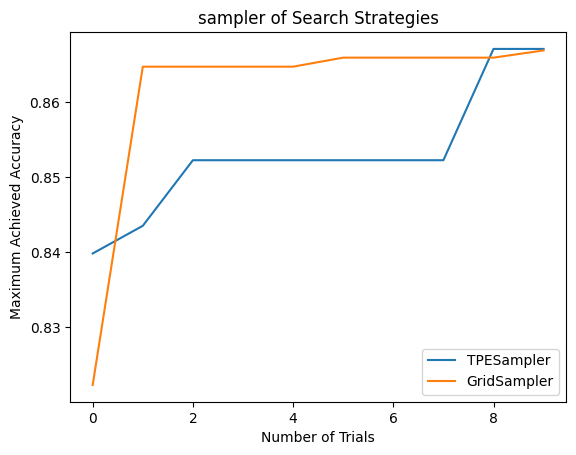

In [41]:
import matplotlib.pyplot as plt

# 横轴：试验次数
x_task1_TPESampler= range(len(task1_accuracies_TPESampler))
x_task1_GridSampler = range(len(task1_accuracies_GridSampler))

# 绘制曲线
plt.plot(x_task1_TPESampler, task1_accuracies_TPESampler, label="TPESampler")
plt.plot(x_task1_GridSampler, task1_accuracies_GridSampler, label="GridSampler")

# 图形设置
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("sampler of Search Strategies")
plt.legend()
plt.show()

In [27]:
task2_no_train_accuracies

[0.75448,
 0.75448,
 0.77064,
 0.77064,
 0.77064,
 0.77064,
 0.82256,
 0.82256,
 0.83404,
 0.83404]

In [ ]:
task2_no_train_accuracies=[0.75448,
 0.75448,
 0.77064,
 0.77064,
 0.77064,
 0.77064,
 0.82256,
 0.82256,
 0.83404,
 0.83404]

In [28]:
task2_with_train_accuracies

[0.86188,
 0.87152,
 0.87152,
 0.87152,
 0.87152,
 0.87152,
 0.87152,
 0.87304,
 0.87304,
 0.87304]

In [ ]:
task2_with_train_accuracies=[0.86188,
 0.87152,
 0.87152,
 0.87152,
 0.87152,
 0.87152,
 0.87152,
 0.87304,
 0.87304,
 0.87304]

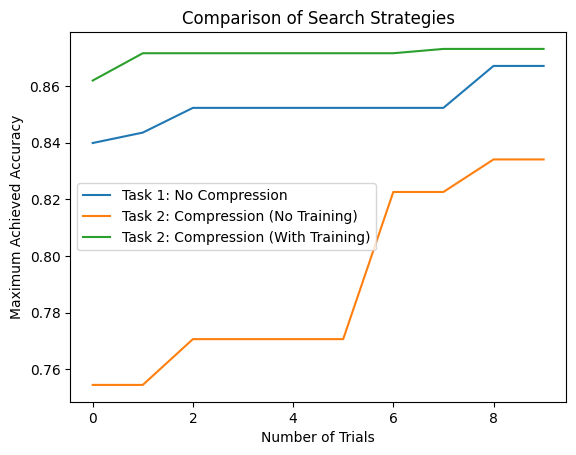

In [29]:
import matplotlib.pyplot as plt

# 横轴：试验次数
x_task1 = range(len(task1_accuracies_TPESampler))
x_task2_no_train = range(len(task2_no_train_accuracies))
x_task2_with_train = range(len(task2_with_train_accuracies))

# 绘制曲线
plt.plot(x_task1, task1_accuracies_TPESampler, label="Task 1: No Compression")
plt.plot(x_task2_no_train, task2_no_train_accuracies, label="Task 2: Compression (No Training)")
plt.plot(x_task2_with_train, task2_with_train_accuracies, label="Task 2: Compression (With Training)")

# 图形设置
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("Comparison of Search Strategies")
plt.legend()
plt.show()


## **clear** 

In [ ]:
# search_space = {
#     "num_layers": [2, 4, 8],
#     "num_heads": [2, 4, 8, 16],
#     "hidden_size": [128, 192, 256, 384, 512],
#     "intermediate_size": [512, 768, 1024, 1536, 2048],
#     "linear_layer_choices": [
#         nn.Linear,
#         Identity,
#     ],
# }

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param])+1)
        # print(param,'idx', chosen_idx)
        # setattr(config, param, search_space[param][chosen_idx])
        setattr(config, param, chosen_idx)
    linear_layer_mapping = {"Linear": nn.Linear, "Identity": Identity}
    trial_model = AutoModelForSequenceClassification.from_config(config)
    
    for name, layer in trial_model.named_modules():
        # print(name,'1111111111111111111111111111111111111111')
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            param_name = f"{name}_type"
            # print(param_name,'222222222222222222222222222222222')
            if param_name not in trial.params:
                break
            new_layer_type = trial.params[param_name]
            new_layer_cls = linear_layer_mapping[new_layer_type]
            if new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)

    return trial_model

import torch
import optuna
from optuna.samplers import TPESampler
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')


def objective(trial, post_compression_training):
    print(f"Trial {trial.number} parameters: {trial.params}")
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    
    mg = MaseGraph(
        model.cpu(),
        hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
        ],
    )
    pipe = CompressionPipeline()

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }

    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0, 
    )
    eval_results = trainer.evaluate()

    if post_compression_training:
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1, 
        )
        trainer.train()
        eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": ["Linear", "Identity"],  # 名称应与 trial.params 中的键一致
}
sampler = GridSampler(search_space)

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=10,
    timeout=60 * 60 * 24,
)

from pathlib import Path
import dill

model = study.best_trial.user_attrs["model"].cpu()

with open(f"{Path.home()}/tutorial_5_best_model_GridSampler.pkl", "wb") as f:
    dill.dump(model, f)

    

In [37]:
import torch
import optuna
from optuna.samplers import TPESampler
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [0, 1],  
}

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_categorical(param, search_space[param])
        setattr(config, param, chosen_idx)

    trial_model = AutoModelForSequenceClassification.from_config(config)
    linear_layer_mapping = {0: nn.Linear, 1: Identity}
    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                "linear_layer_choices",
                search_space["linear_layer_choices"],
            )
            new_layer_cls=linear_layer_mapping[new_layer_cls]
            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model




def objective(trial, post_compression_training):
    print(f"Trial {trial.number} parameters: {trial.params}")
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    
    mg = MaseGraph(
        model.cpu(),
        hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
        ],
    )
    pipe = CompressionPipeline()

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }

    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0, 
    )
    eval_results = trainer.evaluate()

    if post_compression_training:
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1, 
        )
        trainer.train()
        eval_results = trainer.evaluate()
    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

def objective_no_train(trial):
    return objective(trial, post_compression_training=False)

def objective_with_train(trial):
    return objective(trial, post_compression_training=True)

from optuna.samplers import GridSampler, RandomSampler, TPESampler


sampler = GridSampler(search_space)

# 压缩后无训练
study_no_train = optuna.create_study(
    direction="maximize",
    study_name='lab2-2',
    sampler=sampler,
)
study_no_train.optimize(
    objective_no_train, 
    n_trials=10, 
    timeout=60*60*24
)

task2_no_train_accuracies_ = [
    max([t.value for t in study_no_train.trials[:i+1]]) for i in range(len(study_no_train.trials))
]

# 压缩后有训练
study_with_train = optuna.create_study(
    direction="maximize",
    study_name='lab2-3',
    sampler=sampler,
)
study_with_train.optimize(
    objective_with_train, 
    n_trials=10, 
    timeout=60*60*24
)

task2_with_train_accuracies_ = [
    max([t.value for t in study_with_train.trials[:i+1]]) for i in range(len(study_with_train.trials))
]


[I 2025-01-30 13:04:29,733] A new study created in memory with name: lab2-2


Trial 0 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.686900
1000,0.539200
1500,0.426100
2000,0.373300
2500,0.331300
3000,0.357800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[-0.0689, -0.2208, -0.0059,  ...,  0.1035,  0.2595,  0.0526],
         [ 0.3353, -0.2724,  0.1019,  ...,  0.2340,  0.6825, -0.1619],
         [ 0.0671, -0.3364, -0.1903,  ..., -0.0423, -0.5049, -0.0974],
         ...,
         [ 0.4015, -0.1367, -0.3078,  ...,  0.0419, -0.0026,  0.6028],
         [-0.1904,  0.1377, -0.3439,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

[I 2025-01-30 13:07:18,715] Trial 0 finished with value: 0.81964 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_choices': 0}. Best is trial 0 with value: 0.81964.


Trial 1 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695300
1000,0.630400
1500,0.518200
2000,0.466200
2500,0.436100
3000,0.426200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000,  1.4808,  0.2955,  ..., -0.5568,  0.4904,  1.1494],
         [-0.7310,  2.8943, -1.2946,  ..., -0.0000, -0.5452, -0.8227],
         [-0.5038,  1.8583,  0.0609,  ..., -1.9004,  1.6303,  1.8816],
         ...,
         [-0.9953,  1.7959, -0.2010,  ..., -0.9718,  0.0000,  1.3294],
         [-0.0000,  1.9452, -0.3147,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-01-30 13:09:44,952] Trial 1 finished with value: 0.62532 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_choices': 1}. Best is trial 0 with value: 0.81964.


Trial 2 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.679600
1000,0.512300
1500,0.415600
2000,0.365200
2500,0.329600
3000,0.352100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.5196, -0.1363,  0.3847,  ..., -0.4205,  0.3856, -0.0286],
         [ 0.3372,  0.2641, -0.7609,  ..., -0.4810,  0.6301,  0.7607],
         [ 0.3327, -0.2719,  0.2627,  ..., -0.3657, -0.6414,  0.4020],
         ...,
         [-0.0312, -0.1218,  0.1188,  ...,  0.0171,  0.1810, -0.0198],
         [-0.3395,  0.1375,  0.2487,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

[I 2025-01-30 13:12:28,767] Trial 2 finished with value: 0.83852 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 256, 'intermediate_size': 768, 'linear_layer_choices': 0}. Best is trial 2 with value: 0.83852.


Trial 3 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.667200
1000,0.510400
1500,0.442900
2000,0.384600
2500,0.349800
3000,0.338100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[-0.6252, -0.1582,  0.0929,  ..., -0.0648,  0.4130,  0.3393],
         [-0.5548,  0.6568,  0.9134,  ..., -0.4401,  0.0293,  0.5937],
         [ 0.6512,  0.2455,  0.4655,  ..., -0.8343, -0.1768, -0.0642],
         ...,
         [ 0.1379, -0.1096,  0.5035,  ..., -0.4466,  0.6737,  0.3363],
         [-0.0833,  0.1378,  0.6701,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

[I 2025-01-30 13:17:36,238] Trial 3 finished with value: 0.8324 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_choices': 0}. Best is trial 2 with value: 0.83852.


Trial 4 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.660400
1000,0.491200
1500,0.428100
2000,0.373900
2500,0.331900
3000,0.350800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.7708, -0.2370, -0.6866,  ..., -0.0608, -0.9865, -0.4207],
         [ 0.2643,  0.1524, -0.8627,  ...,  0.2603, -0.9917, -1.2257],
         [ 0.2485, -0.5416,  0.4622,  ...,  0.2186, -0.9389, -1.5128],
         ...,
         [ 1.1860, -0.0519, -0.5414,  ...,  0.9565,  0.0998, -0.1150],
         [ 0.4058, -0.1648, -0.5164,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

[I 2025-01-30 13:22:21,415] Trial 4 finished with value: 0.64272 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 1536, 'linear_layer_choices': 0}. Best is trial 2 with value: 0.83852.


Trial 5 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.677100
1000,0.503700
1500,0.421800
2000,0.375300
2500,0.339000
3000,0.348900


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.5047,  0.0594, -0.2547,  ..., -0.0151,  0.0090,  0.2029],
         [ 0.4692,  0.1084, -0.1714,  ..., -0.1187, -0.6879,  0.6875],
         [-0.4218,  0.4522,  0.2942,  ...,  0.1940, -0.8659, -0.0669],
         ...,
         [ 0.4595,  0.0524,  0.0975,  ...,  0.1014, -0.6752, -0.1922],
         [ 0.0458,  0.3959, -0.3070,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

[I 2025-01-30 13:25:07,308] Trial 5 finished with value: 0.83892 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 512, 'linear_layer_choices': 0}. Best is trial 5 with value: 0.83892.


Trial 6 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695300
1000,0.630400
1500,0.518200
2000,0.466200
2500,0.436100
3000,0.426200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000,  1.4808,  0.2955,  ..., -0.5568,  0.4904,  1.1494],
         [-0.7310,  2.8943, -1.2946,  ..., -0.0000, -0.5452, -0.8227],
         [-0.5038,  1.8583,  0.0609,  ..., -1.9004,  1.6303,  1.8816],
         ...,
         [-0.9953,  1.7959, -0.2010,  ..., -0.9718,  0.0000,  1.3294],
         [-0.0000,  1.9452, -0.3147,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-01-30 13:27:40,688] Trial 6 finished with value: 0.62532 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_choices': 1}. Best is trial 5 with value: 0.83892.


Trial 7 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695100
1000,0.647300
1500,0.519700
2000,0.460800
2500,0.431300
3000,0.427000


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[-0.0000,  0.5869, -0.8973,  ...,  2.3368,  0.1710,  0.6897],
         [ 1.0779,  0.8267, -0.3543,  ...,  0.0000,  0.4119, -0.0697],
         [-1.1708, -0.6136, -0.1581,  ..., -0.1473, -0.7989, -0.1935],
         ...,
         [ 0.1613,  1.6230, -1.1366,  ..., -0.1971, -0.0000, -2.3076],
         [ 0.0000,  0.2044, -0.1747,  ...,  1

INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-01-30 13:30:00,921] Trial 7 finished with value: 0.75832 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_choices': 1}. Best is trial 5 with value: 0.83892.


Trial 8 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693400
1000,0.680400
1500,0.588900
2000,0.484100
2500,0.452900
3000,0.456800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000,  1.3556,  0.1865,  ..., -0.2679,  0.1616,  1.4686],
         [ 0.5707,  1.4018,  0.2655,  ...,  1.8919, -0.1715,  1.6864],
         [ 2.6658,  1.7210,  1.0328,  ..., -0.0000,  0.1204,  1.8495],
         ...,
         [ 0.0000, -0.7483,  1.3887,  ...,  0.8102, -0.3608,  1.1143],
         [ 0.9029, -0.0000,  0.0000,  ..., -0

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-01-30 13:31:55,450] Trial 8 finished with value: 0.571 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 128, 'intermediate_size': 1024, 'linear_layer_choices': 1}. Best is trial 5 with value: 0.83892.


Trial 9 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.696200
1000,0.648400
1500,0.510700
2000,0.444900
2500,0.417800
3000,0.417800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000, -0.7022, -0.9145,  ...,  0.1015,  0.2649, -0.5873],
         [ 0.2960, -0.2018,  1.2544,  ...,  0.8111,  0.9692, -1.5426],
         [-0.5975,  1.0236,  0.5618,  ..., -0.1044, -0.2280, -0.1899],
         ...,
         [ 1.6682,  0.1724,  1.1762,  ...,  0.2318, -1.0067, -0.0108],
         [ 0.7644,  0.4859,  2.1783,  ...,  0

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-01-30 13:34:31,749] Trial 9 finished with value: 0.78732 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 1024, 'linear_layer_choices': 1}. Best is trial 5 with value: 0.83892.
[I 2025-01-30 13:34:32,601] A new study created in memory with name: lab2-3


Trial 0 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690300
1000,0.557500
1500,0.467700
2000,0.390500
2500,0.358000
3000,0.373800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.1559, -0.1980,  0.4992,  ...,  0.5684,  0.7775, -0.1472],
         [ 0.3167, -0.1898, -0.2647,  ...,  0.1033,  0.9089,  0.2465],
         [ 0.3497,  0.0813,  0.3439,  ...,  0.1043,  0.0711, -0.0592],
         ...,
         [ 0.5580, -0.4853,  0.2205,  ...,  0.0590,  1.0412,  0.7203],
         [ 0.1410,  0.1705, -0.2401,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.334400
1000,0.280000
1500,0.278200
2000,0.266400
2500,0.272800
3000,0.310300


[I 2025-01-30 13:42:27,362] Trial 0 finished with value: 0.82 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_choices': 0}. Best is trial 0 with value: 0.82.


Trial 1 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694700
1000,0.623000
1500,0.502500
2000,0.462000
2500,0.426000
3000,0.428800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000, -1.3840,  0.3330,  ...,  1.2168, -2.1298,  1.4491],
         [-1.2023, -2.2527, -0.7733,  ..., -0.0000, -0.1981,  0.2370],
         [ 0.1844,  0.5619,  0.2651,  ...,  2.0279, -0.1445,  0.1282],
         ...,
         [-0.1817,  1.8460,  0.2710,  ...,  1.3538,  0.0000,  1.2684],
         [-0.0000, -1.7532, -0.1497,  ...,  1

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.420200
1000,0.335300
1500,0.343400
2000,0.348000
2500,0.339800
3000,0.364300


[I 2025-01-30 13:49:03,549] Trial 1 finished with value: 0.86148 and parameters: {'num_layers': 4, 'num_heads': 2, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_choices': 1}. Best is trial 1 with value: 0.86148.


Trial 2 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.683800
1000,0.532300
1500,0.417400
2000,0.364200
2500,0.329300
3000,0.354600


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.6953, -0.0207,  0.1835,  ..., -0.8030,  0.6033, -0.0211],
         [ 0.7013,  0.0695, -0.9268,  ..., -0.3869,  0.6372,  0.5978],
         [ 0.2163, -0.1433,  0.2821,  ..., -0.4373, -0.1526,  0.0039],
         ...,
         [ 0.3428, -0.1674,  0.0988,  ..., -0.1875,  0.8158, -0.2474],
         [ 0.0882, -0.0846, -0.0374,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.307600
1000,0.256000
1500,0.254500
2000,0.266500
2500,0.264100
3000,0.296700


[I 2025-01-30 13:56:10,720] Trial 2 finished with value: 0.86416 and parameters: {'num_layers': 8, 'num_heads': 2, 'hidden_size': 256, 'intermediate_size': 768, 'linear_layer_choices': 0}. Best is trial 2 with value: 0.86416.


Trial 3 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.655800
1000,0.500500
1500,0.411100
2000,0.374300
2500,0.338100
3000,0.354700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[-0.7016, -0.2243, -0.4617,  ...,  0.2928,  0.2565,  0.5192],
         [-0.9047,  0.8033,  0.0576,  ..., -0.3545, -0.4901, -0.1503],
         [ 0.0054,  0.5671,  0.2231,  ..., -0.3317, -0.5778,  0.1304],
         ...,
         [ 0.2673, -0.0447,  0.9729,  ...,  0.0138,  0.2293, -0.2241],
         [-0.6404, -0.1133,  1.0281,  ..., -0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.306300
1000,0.251500
1500,0.248200
2000,0.257000
2500,0.256100
3000,0.292100


[I 2025-01-30 14:09:26,045] Trial 3 finished with value: 0.87612 and parameters: {'num_layers': 2, 'num_heads': 16, 'hidden_size': 512, 'intermediate_size': 2048, 'linear_layer_choices': 0}. Best is trial 3 with value: 0.87612.


Trial 4 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.649100
1000,0.491800
1500,0.406300
2000,0.363600
2500,0.334800
3000,0.343500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0623, -0.1365, -0.4904,  ...,  0.1689, -1.2868, -0.4743],
         [-0.3705, -0.5352, -0.8662,  ...,  0.3223, -0.4097, -0.6384],
         [-0.0577, -0.5997,  0.0773,  ...,  0.7314, -0.8695, -1.2691],
         ...,
         [-0.0193, -0.0878, -0.5124,  ...,  0.6699, -0.0803,  0.0108],
         [-0.3781, -0.6647, -0.8749,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.305600
1000,0.257900
1500,0.254000
2000,0.267300
2500,0.259400
3000,0.287500


[I 2025-01-30 14:20:20,535] Trial 4 finished with value: 0.85772 and parameters: {'num_layers': 2, 'num_heads': 4, 'hidden_size': 512, 'intermediate_size': 1536, 'linear_layer_choices': 0}. Best is trial 3 with value: 0.87612.


Trial 5 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.673600
1000,0.504800
1500,0.406700
2000,0.366600
2500,0.336300
3000,0.356100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 1.8994e-01,  4.3298e-01, -1.3970e-01,  ..., -4.8485e-01,
           3.1074e-02,  2.9138e-02],
         [ 2.6044e-01,  5.6974e-01, -1.1295e-01,  ..., -6.9825e-01,
          -5.7118e-01,  2.9580e-01],
         [-4.2294e-01,  3.0364e-01,  2.1512e-01,  ..., -1.3933e-01,
          -6.0753e-01,  6.9640e-04],
         ...,
         [ 1.6

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Tr

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.305800
1000,0.250100
1500,0.254800
2000,0.261300
2500,0.266300
3000,0.299600


[I 2025-01-30 14:26:26,051] Trial 5 finished with value: 0.85136 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 256, 'intermediate_size': 512, 'linear_layer_choices': 0}. Best is trial 3 with value: 0.87612.


Trial 6 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694700
1000,0.623000
1500,0.502500
2000,0.462000
2500,0.426000
3000,0.428800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000, -1.3840,  0.3330,  ...,  1.2168, -2.1298,  1.4491],
         [-1.2023, -2.2527, -0.7733,  ..., -0.0000, -0.1981,  0.2370],
         [ 0.1844,  0.5619,  0.2651,  ...,  2.0279, -0.1445,  0.1282],
         ...,
         [-0.1817,  1.8460,  0.2710,  ...,  1.3538,  0.0000,  1.2684],
         [-0.0000, -1.7532, -0.1497,  ...,  1

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.420200
1000,0.335300
1500,0.343400
2000,0.348000
2500,0.339800
3000,0.364300


[I 2025-01-30 14:32:09,665] Trial 6 finished with value: 0.86148 and parameters: {'num_layers': 4, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 2048, 'linear_layer_choices': 1}. Best is trial 3 with value: 0.87612.


Trial 7 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.696100
1000,0.653700
1500,0.539600
2000,0.479200
2500,0.442100
3000,0.439800


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[-0.0000, -0.3036,  1.8436,  ...,  0.2483, -0.4730, -0.3447],
         [-0.2775,  1.3752,  0.3571,  ..., -0.0000, -2.6193, -2.0396],
         [-0.0866,  1.4974, -1.9218,  ..., -0.2407, -1.5456,  0.0691],
         ...,
         [-1.2056,  0.1187, -0.9846,  ..., -2.5725, -0.0000,  0.7309],
         [-0.0000,  0.0960,  0.6081,  ...,  0

INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.437300
1000,0.352200
1500,0.350900
2000,0.345400
2500,0.342700
3000,0.382500


[I 2025-01-30 14:37:17,280] Trial 7 finished with value: 0.85812 and parameters: {'num_layers': 8, 'num_heads': 4, 'hidden_size': 192, 'intermediate_size': 1536, 'linear_layer_choices': 1}. Best is trial 3 with value: 0.87612.


Trial 8 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.691700
1000,0.674700
1500,0.592600
2000,0.513500
2500,0.465400
3000,0.468900


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[ 0.0000,  1.4423,  0.9203,  ...,  1.1949,  0.6540,  0.1729],
         [ 0.2927, -0.6947,  0.4026,  ...,  1.8183,  0.1756, -0.1119],
         [ 0.9924,  0.0245, -0.4948,  ...,  0.0000,  1.1784,  0.5264],
         ...,
         [ 0.0000, -1.6251,  2.0819,  ...,  1.0602,  1.6812, -0.1877],
         [ 1.9859, -0.0000,  0.0000,  ...,  0

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.479800
1000,0.376900
1500,0.369400
2000,0.361800
2500,0.354600
3000,0.378000


[I 2025-01-30 14:41:29,273] Trial 8 finished with value: 0.85352 and parameters: {'num_layers': 4, 'num_heads': 8, 'hidden_size': 128, 'intermediate_size': 1024, 'linear_layer_choices': 1}. Best is trial 3 with value: 0.87612.


Trial 9 parameters: {}


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.696900
1000,0.655800
1500,0.505300
2000,0.448400
2500,0.416500
3000,0.418500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[-0.0000, -0.1981,  1.7492,  ..., -0.7854,  0.9792, -0.5460],
         [ 1.0782,  0.2587, -0.9251,  ..., -1.6786, -0.0464, -1.5547],
         [ 0.4018,  0.4364,  0.2544,  ..., -0.1612,  0.6911, -0.8639],
         ...,
         [ 1.1194,  1.7444, -0.5296,  ...,  0.0908,  0.1422, -0.4749],
         [ 2.2950,  0.4837,  0.4528,  ..., -0

/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407200
1000,0.331100
1500,0.348900
2000,0.332000
2500,0.341000
3000,0.354400


[I 2025-01-30 14:46:13,195] Trial 9 finished with value: 0.86552 and parameters: {'num_layers': 4, 'num_heads': 16, 'hidden_size': 256, 'intermediate_size': 1024, 'linear_layer_choices': 1}. Best is trial 3 with value: 0.87612.


In [38]:
task2_no_train_accuracies_

[0.81964,
 0.81964,
 0.83852,
 0.83852,
 0.83852,
 0.83892,
 0.83892,
 0.83892,
 0.83892,
 0.83892]

In [39]:
task2_with_train_accuracies_

[0.82,
 0.86148,
 0.86416,
 0.87612,
 0.87612,
 0.87612,
 0.87612,
 0.87612,
 0.87612,
 0.87612]

In [3]:
task2_no_train_accuracies_pre

[0.7928,
 0.7928,
 0.79796,
 0.79796,
 0.79796,
 0.79796,
 0.82844,
 0.82844,
 0.85104,
 0.85104]

In [4]:
task2_with_train_accuracies_pre

[0.85784,
 0.85784,
 0.8694,
 0.8694,
 0.8694,
 0.87132,
 0.87612,
 0.87612,
 0.87612,
 0.87612]

In [5]:
task1_accuracies_GridSampler=[0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86616,
 0.86748,
 0.86748,
 0.86748]

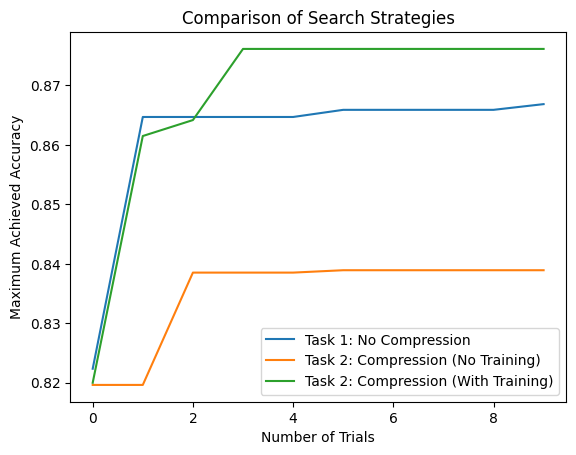

In [42]:
import matplotlib.pyplot as plt

# 横轴：试验次数
x_task1 = range(len(task1_accuracies_GridSampler))
x_task2_no_train = range(len(task2_no_train_accuracies_))
x_task2_with_train = range(len(task2_with_train_accuracies_))

# 绘制曲线
plt.plot(x_task1, task1_accuracies_GridSampler, label="Task 1: No Compression")
plt.plot(x_task2_no_train, task2_no_train_accuracies_, label="Task 2: Compression (No Training)")
plt.plot(x_task2_with_train, task2_with_train_accuracies_, label="Task 2: Compression (With Training)")

# 图形设置
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("Comparison of Search Strategies")
plt.legend()
plt.show()
